Import libraries

In [ ]:
import os
import glob
import pandas as pd
import numpy as np
from pyopenms import *

# `GNPSExport Workflow`

This workflow consists of 4 steps that generate a directory with all the files necessary to create a FBMN job at GNPS. (see https://ccms-ucsd.github.io/GNPSDocumentation/featurebasedmolecularnetworking-with-openms/) 

![GNPSExport.png](images/GNPSExport.png)
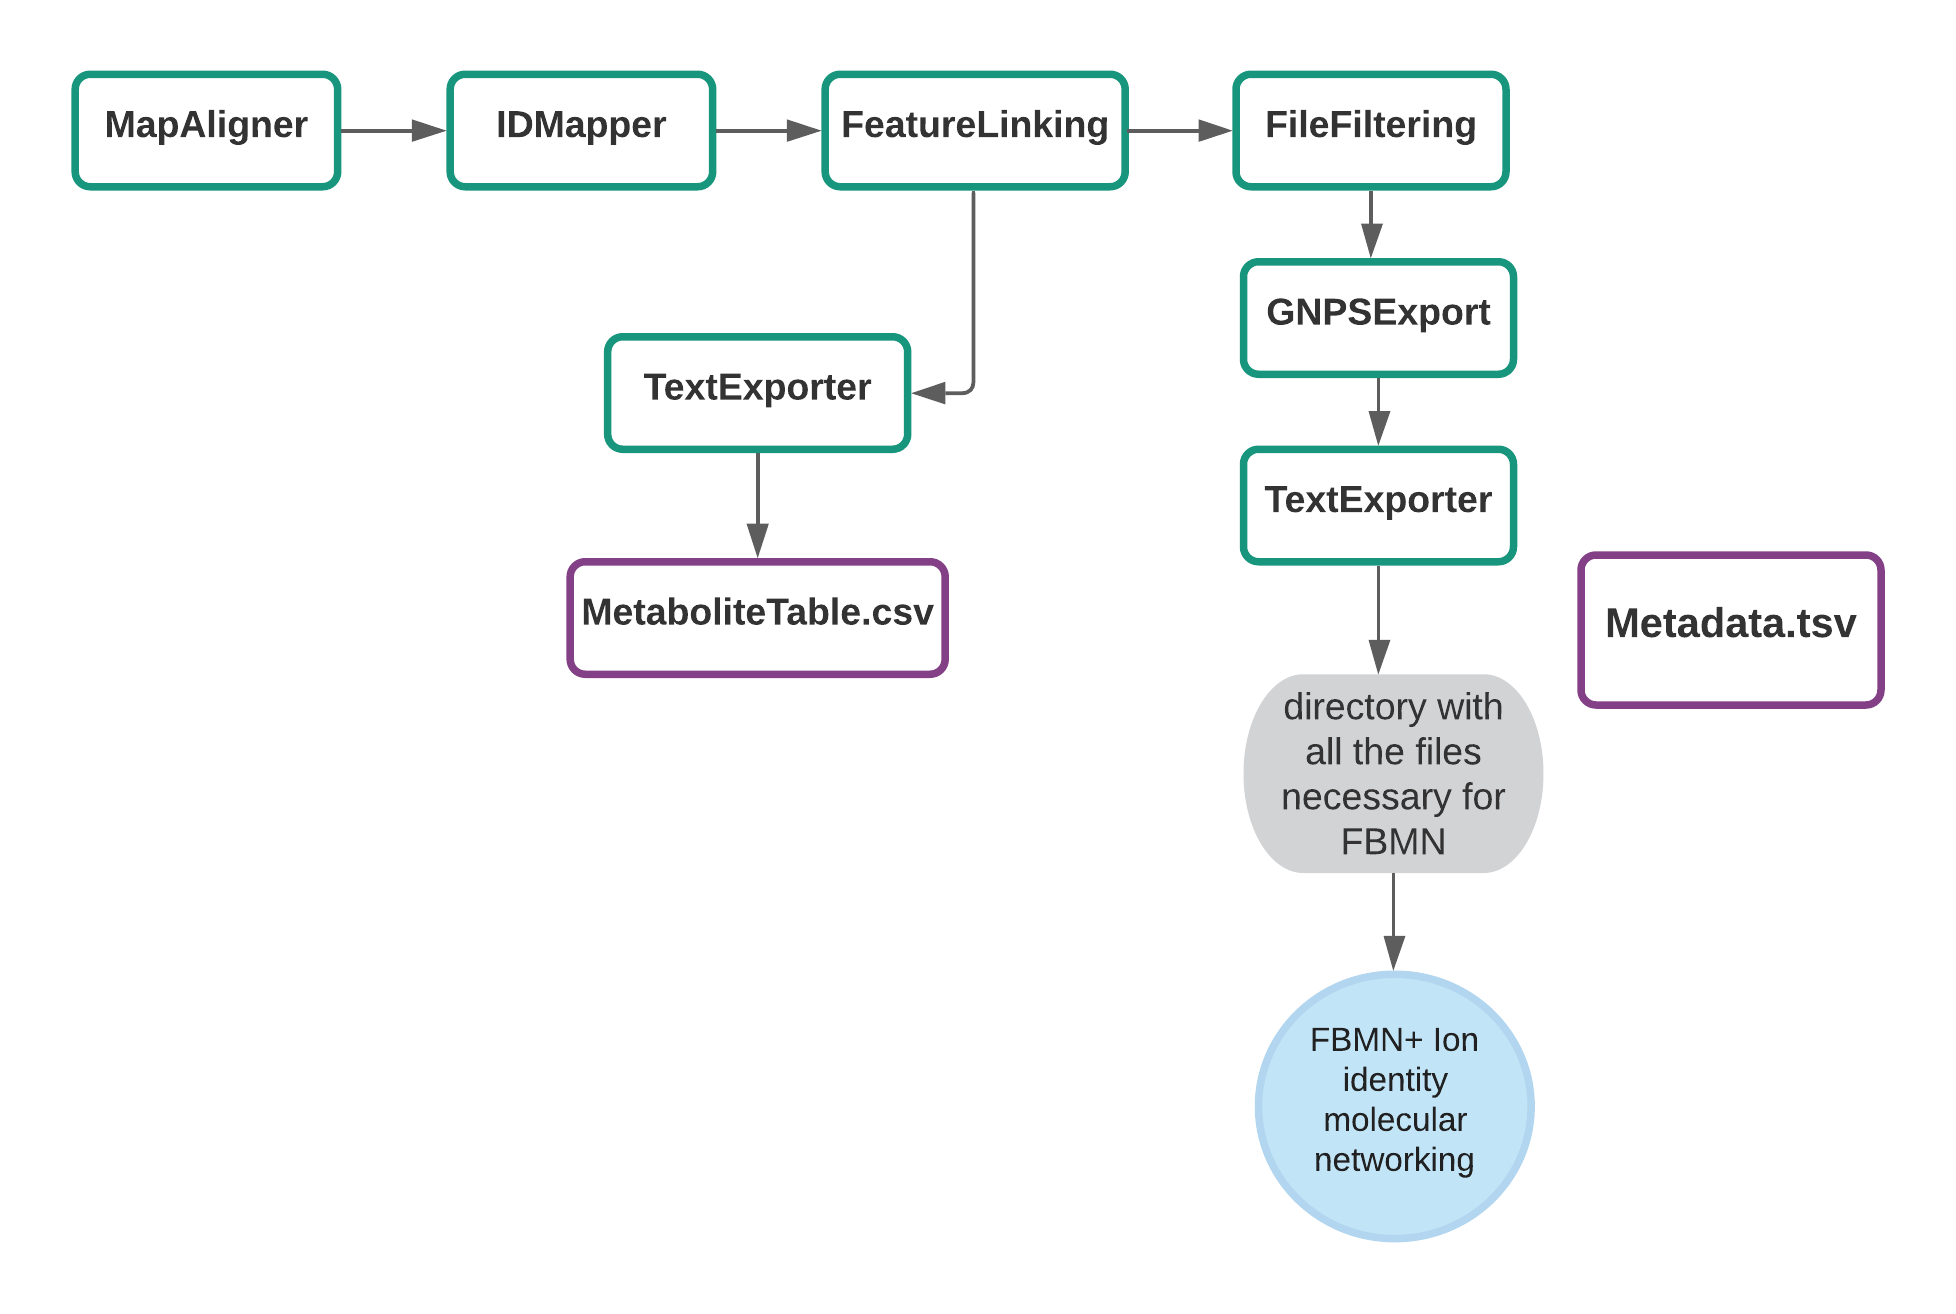

#### `1) Create a metadata tsv file for GNPS`

In [ ]:
path= os.path.join("results", "GNPSexport")
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

# Create a metadata table from the list of mzML files 

metadata = pd.DataFrame()
metadata["filename"] = [file for file in os.listdir(os.path.join("data", "mzML")) if file.endswith(".mzML")]
metadata["ATTRIBUTE_MAPID"]= ["MAP" + str(i) for i in range(len(metadata))]
metadata['ATTRIBUTE_genomeID']=metadata['filename'].str.extract(r'(NBC_?\d*)')
metadata['ATTRIBUTE_genomeIDMDNA']=metadata['filename'].str.extract(r'(MDNAWGS?\d*|MDNA_WGS_?\d*)')
metadata['ATTRIBUTE_genomeID']=metadata['ATTRIBUTE_genomeID'].fillna(metadata['ATTRIBUTE_genomeIDMDNA'])
metadata["ATTRIBUTE_media"]= metadata['filename'].str.extract(r'(ISP2|DNPM|FPY12|MA|soyM\d*)')
metadata["ATTRIBUTE_comment"]= metadata['ATTRIBUTE_genomeID'].astype(str) +"_" + metadata["ATTRIBUTE_media"].astype(str)
metadata=metadata.drop(columns="ATTRIBUTE_genomeIDMDNA")
metadata.to_csv(os.path.join(path, "metadata.tsv"), sep='\t')
metadata

Import aligned feature files and load them to a FeatureMap() file

#### `2) File Filter` 

Remove the features that do not have an MS2 pattern

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/release/latest/html/TOPP_FileFilter.html

In [ ]:
path= os.path.join("results", "interim", "GNPSexport")
isExist= os.path.exists(path)
if not isExist:
    os.mkdir(path)

input_consensus= os.path.join("results", "interim","Requantification", "consensus.consensusXML")
cmap = ConsensusMap()
ConsensusXMLFile().load(input_consensus, cmap)
new_map= ConsensusMap(cmap)
new_map.clear(False)
for f in cmap:
    if f.getPeptideIdentifications() !=[]:
        new_map.push_back(f)
        
Consensus_file= os.path.join(path ,'filtered' + ".consensusXML")
ConsensusXMLFile().store(Consensus_file, new_map)

#### `3) GNPSexport `

The algorithm creates an MGF file with only the MS2 information of all files (introduce mzml files with spaces between them)

###### Documentation: https://abibuilder.informatik.uni-tuebingen.de/archive/openms/Documentation/nightly/html/TOPP_GNPSExport.html

In [ ]:
consensus= os.path.join(path, "filtered.consensusXML")
input_mzml_files=sorted(glob.glob(os.path.join("results", "interim", "Requantification", "MapAligned_*.mzML")))
out_file= os.path.join("results", "GNPSexport", "MSMS.mgf")

spectra_clustering= GNPSMGFFile()

spectra_clustering.run(String(consensus), [s.encode() for s in input_mzml_files], String(out_file))

#### `4) FeatureQuantificationTable.txt`

Convert the consensusXML file to a txt file for GNPS

In [ ]:
cmap = ConsensusMap()
ConsensusXMLFile().load(consensus, cmap)

# get intensities as a DataFrame
intensities = cmap.get_intensity_df()

# get meta data as DataFrame
meta_data = cmap.get_metadata_df()

# you can concatenate these two for a "result" DataFrame
result = pd.concat([meta_data, intensities], axis=1)

# if you don't need labeled index, remove it (and/or save with index = False)
result.reset_index(drop=True, inplace=True)

idx = 0
new_col = "CONSENSUS"  # can be a list, a Series, an array or a scalar   
result.insert(loc=idx, column='#CONSENSUS', value=new_col)   
result= result.rename(columns= {"charge": "charge_cf", "RT": "rt_cf", "mz": "mz_cf", "quality": "quality_cf", "width": "width_cf"})
result= result.drop(["sequence"], axis= 1)
result= result.sort_index(axis=1)

filemeta= cmap.getColumnHeaders()
mapIDs = [k for k in filemeta.keys()]
filename= []
size=[]
label= []
for header in filemeta.values():
    files= header.filename
    sizes= header.size
    labels= header.label
    filename.append(files)
    size.append(sizes)
    label.append(labels)

dict = {'id': mapIDs, 'filename': filename,'label': label,'size': size}
DF= pd.DataFrame(dict)
DF["id"] = "intensity_"+ (DF["id"]).astype(str)

cols= result.columns
for col in cols:
    for i, path_new in enumerate(filename):
        if path_new== col:
            name= DF["id"][i]
            result.rename(columns={col: name}, inplace=True)

cols = result.columns
preordered = ["#CONSENSUS", "charge_cf", "rt_cf", "mz_cf", "quality_cf", "width_cf"]
new_cols = preordered + [c for c in result.columns if c not in preordered]
new_df = result.reindex(columns=new_cols)
new_df.to_csv(os.path.join(path, "FeatureMatrix.csv"), sep="\t", index=None)
new_df

Add the Map ID and path information from the metadata table:

In [ ]:
metadata= pd.read_csv(os.path.join("results", "GNPSexport", "metadata.tsv"), sep="\t", index_col="Unnamed: 0")
metadata= metadata.filter(["filename", "ATTRIBUTE_MAPID"])
metadata["#MAP"]= ("MAP")
metadata["id"]= metadata["ATTRIBUTE_MAPID"].str.extract(r"(\d)")
metadata= metadata.drop(columns="ATTRIBUTE_MAPID")
metadata= metadata[["#MAP", "id", "filename"]]
metadata.to_csv(os.path.join(path, "mapIDs.csv"), sep="\t", index=None)
metadata

In [ ]:
map_file= os.path.join(path, "mapIDs.csv")
feature_file= os.path.join(path, "FeatureMatrix.csv")
merged_file= os.path.join("results", "GNPSexport", "FeatureQuantificationTable.txt")

with open(map_file, "r") as map_file:
    map_text = map_file.read()

with open(feature_file, "r") as feature_file:
    feature_text = feature_file.read()

with open(merged_file, "w") as merged_file:
    merged_file.write(map_text + feature_text)

#### `5) IIMN (Ion Identity Molecular Networking)`:

https://ccms-ucsd.github.io/GNPSDocumentation/fbmn-iin/#iimn-networks-with-collapsed-ion-identity-edges

In [ ]:
df = cmap.get_df()
df.insert(0, "best ion", [f.getMetaValue("best ion") for f in cmap])
df["LinkedGroups"] = [set(s.decode() for s in f.getMetaValue("LinkedGroups")) for f in cmap]
df.insert(0, "FEATURE_ID", ["e_" + str(cf.getUniqueId()) for cf in cmap])
df["partners"] = ""
for i in df.index:
    for j in df.iloc[i:].index:
        if i == j:
            continue
        if df.loc[i, "LinkedGroups"].intersection(df.loc[j, "LinkedGroups"]):
            if df.loc[i, "partners"]:
                df.loc[i, "partners"] += ";"
            if df.loc[j, "partners"]:
                df.loc[j, "partners"] += ";"
            df.loc[i, "partners"] += df.loc[j, "FEATURE_ID"]
            df.loc[j, "partners"] += df.loc[i, "FEATURE_ID"]
df = df.drop(["sequence", "LinkedGroups"], axis=1)
df.to_csv(os.path.join("results","GNPSexport", "SuppPairs.tsv"), sep="\t", index=False)